In [2]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
#from evaluation_functions import *
from functions_ import *
from plotting import *
from Bio import SeqIO
import matplotlib.patches as patches
from collections import Counter
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from characterization_from_blast_alignments import *
import scipy

In [31]:
from importlib import reload
import characterization_from_blast_alignments
reload(characterization_from_blast_alignments)
from characterization_from_blast_alignments import *

In [3]:
### define the necessary variables

base_dir = os.getcwd() 

catch_left = 'actgtctgttttcctgaattc'.upper() # region before retron seq
catch_right = 'gtacgaattcaggaaa'.upper() # region after retron seq

Barcodes = {"BC1_fwd": "AAGG", 
            "BC1_rev" : "ATCA", 
            "BC2_fwd":	"AGTC",
            "BC2_rev":	"GCCG", 
            "BC3_fwd":	"AGGA",
            "BC3_rev":	"AATT",}



Primer_seq = {"_fwd": "agcgagaggtttatcattaaggtcaac".upper(),
              "_rev":"aggcttttgacttggctgaggag".upper()}

Primer_out_of_triplets = {"_fwd": 0, 
                          "_rev": 0}


genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [21]:

### make sure to run the second code chunk before this one, since the primer dict could have been updated during analysis of the repeated seq run of S2, S3
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',] 
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/']
#ref_gene = amplicon_seq

used_BCs = ["BC1", "BC2", "BC3"]

variant = "RetronLib"
filter_for_n_mut = False
read_len_treshold = None

## variant 4
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities, base_dir = f"{os.getcwd()}/data/fastq/P0111_Retrons"
)

all_reads, all_ids = demultiplex_reads(a_seq, b_seq, ref_gene = None ,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = used_BCs, Sections = [""], max_mismatch_primerseq = 5, filter_for_n_mut = filter_for_n_mut, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold= read_len_treshold, Primer_out_of_triplets= Primer_out_of_triplets, cut_primer_start=False, cut_BC_seq=True)


total reads 92086
[0, 2, 6, 8, 11, 12, 17, 18, 24, 25]
33237
6941 b reads are empty
3377 a reads are empty
24860 forward reads with matching BC and primer seq
18871 reads with index swapping
BC1  24860 reads before filtering
################# Done: BC1 
################# Done: BC1
[3, 5, 7, 9, 16, 19, 20, 29, 31, 34]
26794
5306 b reads are empty
2637 a reads are empty
19470 forward reads with matching BC and primer seq
15921 reads with index swapping
BC2  19470 reads before filtering
################# Done: BC2 
################# Done: BC2
[1, 13, 14, 15, 21, 22, 23, 28, 32, 36]
13558
4851 b reads are empty
1180 a reads are empty
9280 forward reads with matching BC and primer seq
12687 reads with index swapping
BC3  9280 reads before filtering
################# Done: BC3 
################# Done: BC3


In [22]:
## cut all reads to region of interest (complementary region of the retron that will in the end bind to the target region): 
for key, reads in all_reads.items():
    if "R1" in key: 
        all_reads[key] = [read[read.index(catch_left)+len(catch_left):read.index(catch_right)] if catch_left in read and catch_right in read else "" for read in reads ]
        all_reads
    elif "R2" in key:
        all_reads[key] = [read[read.index(dna_rev_comp(catch_right))+len(catch_right):read.index(dna_rev_comp(catch_left))] if dna_rev_comp(catch_right) in read  and dna_rev_comp(catch_left) in read else "" for read in reads ]


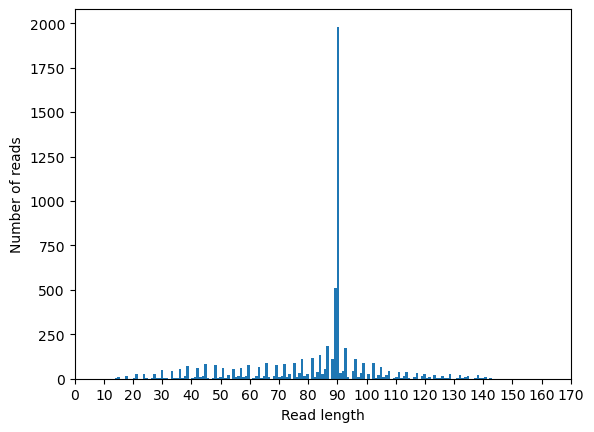

In [27]:
plt.hist([len(read) for read in all_reads["BC3__R1"]if read != ""], bins=150)
plt.ylabel("Number of reads")
plt.xticks(np.arange(0, 180,10 ))
#plt.xlim(80,100)
plt.xlabel("Read length")
plt.show()

In [ ]:
# Bc = "BC1"

# Read_dir = "R2"

# reads = all_reads[f"{Bc}__{Read_dir}"] if Read_dir == "R1" else [dna_rev_comp(r) for r in all_reads[f"{Bc}__{Read_dir}"]]

# output_file = f"data/fastq/P0111_Retrons/{variant}_{Bc}_Nt_filt_{Read_dir}_001.fasta"
# sequences = [SeqIO.SeqRecord(Seq(read), id = all_ids[f"{Bc}__{Read_dir}"][i], description = f"{variant} {Bc} DNA sequence") for i, read in enumerate(reads)]

# count = SeqIO.write(sequences, output_file, "fasta")
# with open(output_file, "w") as output_handle:
#     SeqIO.write(sequences, output_handle, "fasta")
# print("Saved %i records to %s" % (count, output_file))

In [ ]:
same_bc = 0
diff_bc = 0

BC_corresp = { "AAGG" : "ATCA", 
            "AGTC" : "GCCG", 
            "AGGA" :	"AATT"}

for idx, a_read in enumerate(a_seq): 
    Bc1 = a_read[:4]
    if Bc1 not in BC_corresp.keys():
        diff_bc += 1
        continue
    if BC_corresp[Bc1] == b_seq[idx][:4]:
        same_bc += 1  
    else: 
        diff_bc += 1
        
print("same BC: ", same_bc)
print("idx swapping BC: ", diff_bc)
print(diff_bc/(same_bc+diff_bc), " of reads have swapped BCs") # roughly 40% !!!!!

In [64]:
import json

Bc = "BC3"
read_dir = "R1"
variant = "RetronLib"

# Open the JSON file and load it as a dictionary
with open(f"data/blastoutput/{variant}_{Bc}_Nt_filt_{read_dir}_001.out", "r") as file:
    blast_output = json.load(file)

# Now 'data' is a Python dictionary
print(type(blast_output))  # Should output: <class 'dict'>


blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()


ref_alignment_region = "CAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGC" ## region used for alignment of reads 

LOV_startseq = "ttagccacaa".upper()
LOV_endseq = "ggcggccaaa".upper()


LOV2_start_idx = ref_alignment_region.index(LOV_startseq)
LOV2_end_idx = ref_alignment_region.index(LOV_endseq) + len(LOV_endseq)

FigFolder = f"{os.getcwd()}/output/P0111_RetronLib/{Bc}_{read_dir}/"
if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)  



<class 'dict'>


In [65]:
RL_encoded_mutations = [0]*len(ref_alignment_region) # list to store the number of changes at each position
RL_encoded_insertions = [0]*len(ref_alignment_region) # list to store the number of indels at each position
RL_encoded_deletions = [0]*len(ref_alignment_region) # list to store the number of indels at each position

print("total reads:", len(blast_alignments))
for alignment in blast_alignments:
    qseq = alignment["hsps"][0]["qseq"].upper()
    hseq = alignment["hsps"][0]["hseq"].upper()
    seq_id = alignment["description"][0]["title"]
    midline = alignment["hsps"][0]["midline"]

    query_from  = alignment["hsps"][0]["query_from"] -1 # -1 to correct for 0-based indexing in python
    query_to = alignment["hsps"][0]["query_to"]

    # if query_to - query_from < 85 or query_to - query_from > 95: 
    #     continue
    
    if "-" in qseq or "-" in hseq:
        # Track how much insertions have shifted the sequence
        shift = 0  

        for i, nt in enumerate(qseq):
            pos = query_from + i - shift  # Adjust position for past insertions
            if hseq[i] == "-":

                RL_encoded_deletions[pos] += 1 ## here, no shift + 1 needed since deletions in the **read** do not infere with the indexing when mappping to the **reference** (no shift of the ref position)
            if nt == "-":
                RL_encoded_insertions[pos] += 1  # Mark insertion at the previous reference position
                shift += 1  # Increase shift due to insertion  
    
    else: 
        hotencoding = [0 if midline[i] == "|" else 1 for i in range(len(midline))]
        for pos, val in enumerate(hotencoding):
            RL_encoded_mutations[query_from + pos] += val
    

total reads: 5797


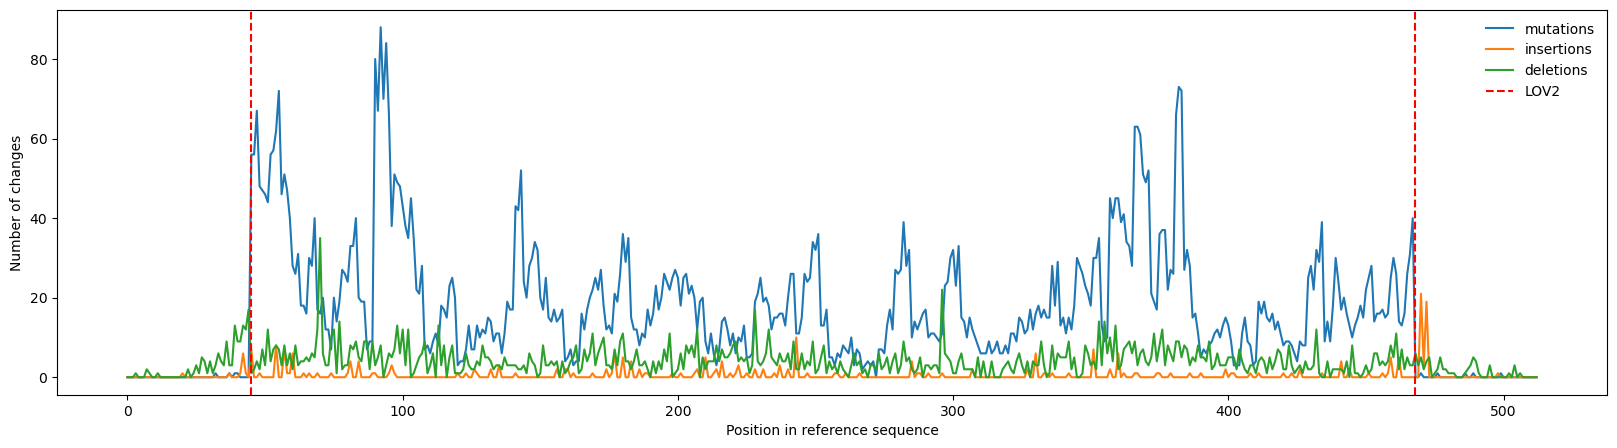

In [66]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(RL_encoded_mutations, label="mutations")
plt.plot(RL_encoded_insertions, label = "insertions")
plt.plot(RL_encoded_deletions, label = "deletions")
plt.axvline(LOV2_start_idx, color="red", linestyle="--", label="LOV2")
plt.axvline(LOV2_end_idx, color="red", linestyle="--",)
plt.legend(frameon=False)
plt.xlabel("Position in reference sequence")
plt.ylabel("Number of changes")
plt.savefig(f"{FigFolder}/{Bc}_RL_encoded_changes.pdf")
plt.show()


<class 'dict'>
24029 alignments before filtering for LOV2 insertion site
18732 alignments after filtering for LOV2 insertion site
59 sequences are excluded, since LOV2 start site could not be found in the ref (due to '-' i.e. insertions at the start of LOV2)
686 sequences with off target indels are excluded
17987 sequences are included in the enrichment analysis


<Figure size 640x480 with 0 Axes>

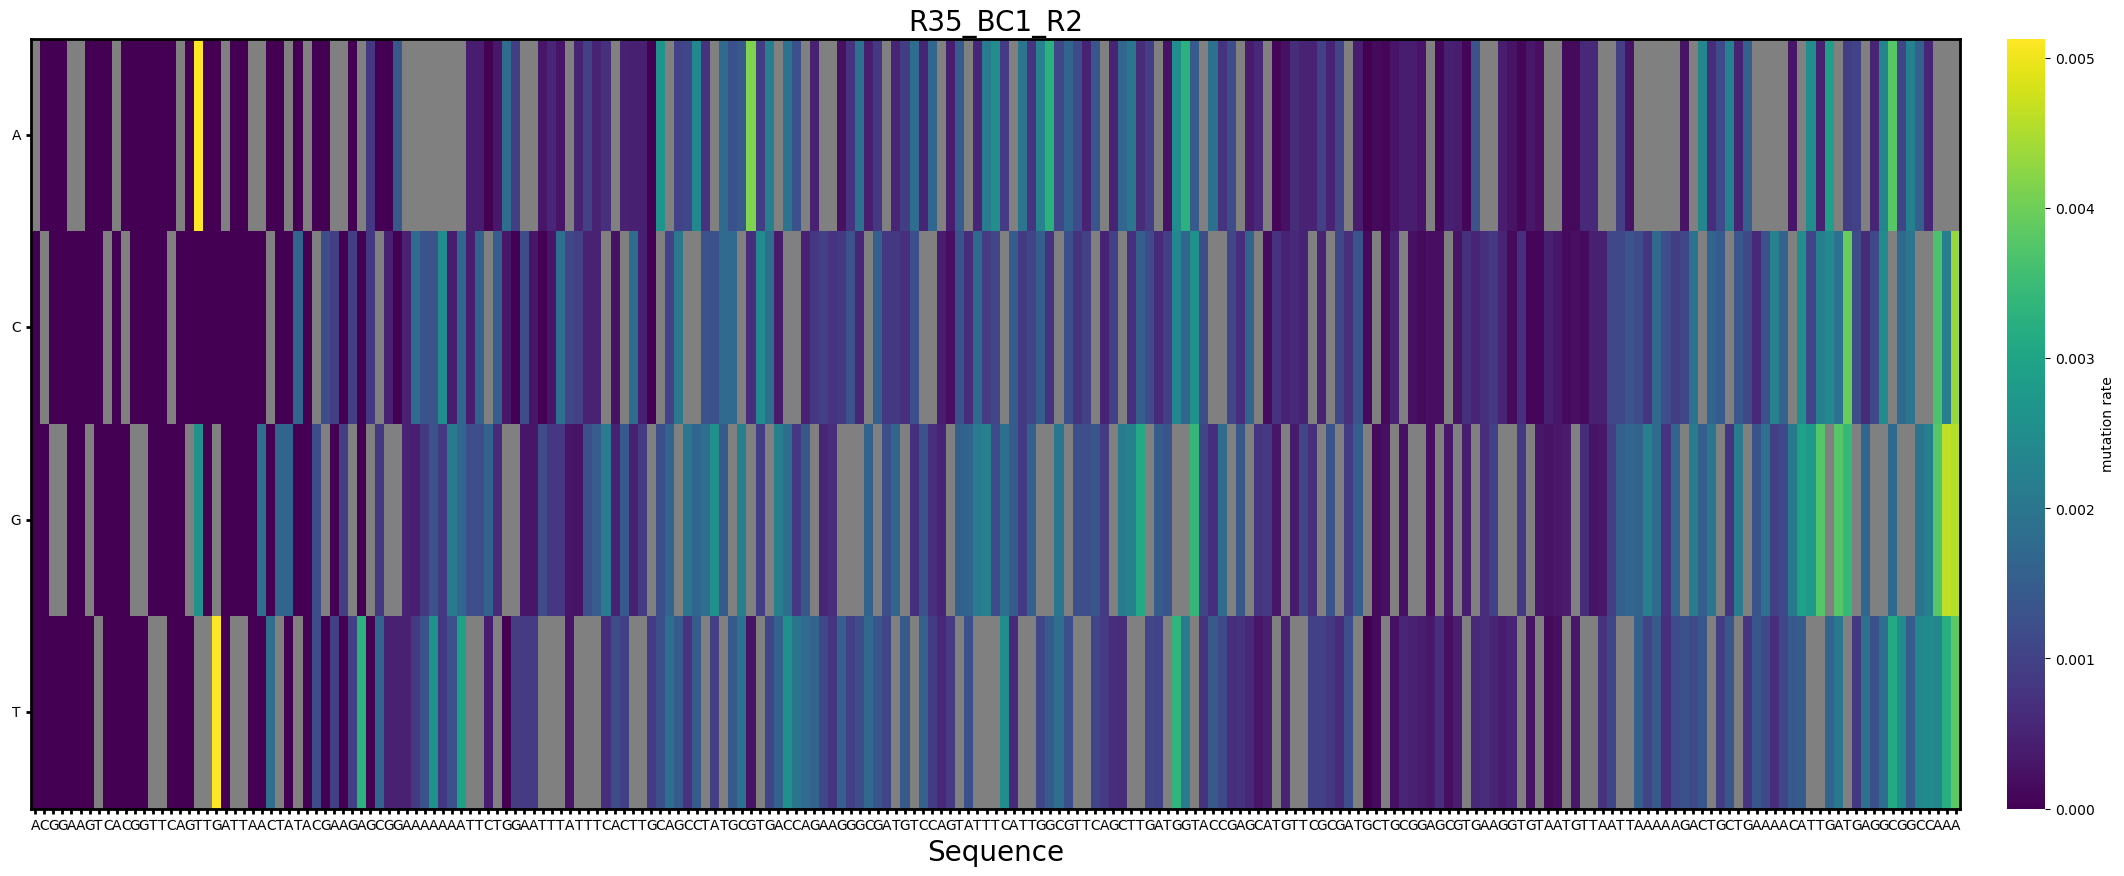

In [101]:
import json

Bc = "BC1"
read_dir = "R2"
variant = "R35"

# Open the JSON file and load it as a dictionary
with open(f"data/blastoutput/{variant}_{Bc}_Nt_filt_{read_dir}_001.out", "r") as file:
    blast_output = json.load(file)

# Now 'data' is a Python dictionary
print(type(blast_output))  # Should output: <class 'dict'>


blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()
LOV_startseq = "ttagccacaa".upper()
LOV_endseq = "ggcggccaaa".upper()


LOV2_gene = "ttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaa".upper()

amplicon_seq = "cgccgcatggaagcgattaacgaaagcagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcctgcatccgccgatggataaccgcgtgcg".upper()[:-2]## region used for alignment of reads


LOV2_startidx = amplicon_seq.index(LOV_startseq)
LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)



### filter blast alignments for regions that include LOV2 start site (include 10 nucleotides before and after the LOV2 start site)
print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")

#strand = blast_alignments[0]["hsps"][0]["hit_strand"] # "Minus" or "Plus"
filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx 

blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]
print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")


cut_site_seq = LOV_startseq if read_dir=="R1" else LOV_endseq

linker_alignments, LOV2_alignments = divide_alignments(blast_alignments, cut_site_seq, read_dir=read_dir)

data_type = "DNA"
all_variants, indels_freq,  enrichment_counts, enrichment_relative = characterize_DMS_blast_alignment(LOV2_alignments, ref = LOV2_gene, data_type=data_type,read_dir=read_dir)

# if data_type == "AA":
#     annot_ref = LOV2_prot[:enrichment_relative.shape[1]] if read_dir == "R1" else LOV2_prot[-enrichment_relative.shape[1]:]
if data_type == "DNA":
    annot_ref = LOV2_gene[:enrichment_relative.shape[1]] if read_dir == "R1" else LOV2_gene[-enrichment_relative.shape[1]:]

plot_mutation_enrichment(enrichment_relative, ref_seq=annot_ref, samplename=f"{variant}_{Bc}_{read_dir}", data_type=data_type, vmax=None)

In [102]:
indels_freq = indels_freq.iloc[:,:200] if read_dir == "R1" else indels_freq.iloc[:,-200:]

<Figure size 640x480 with 0 Axes>

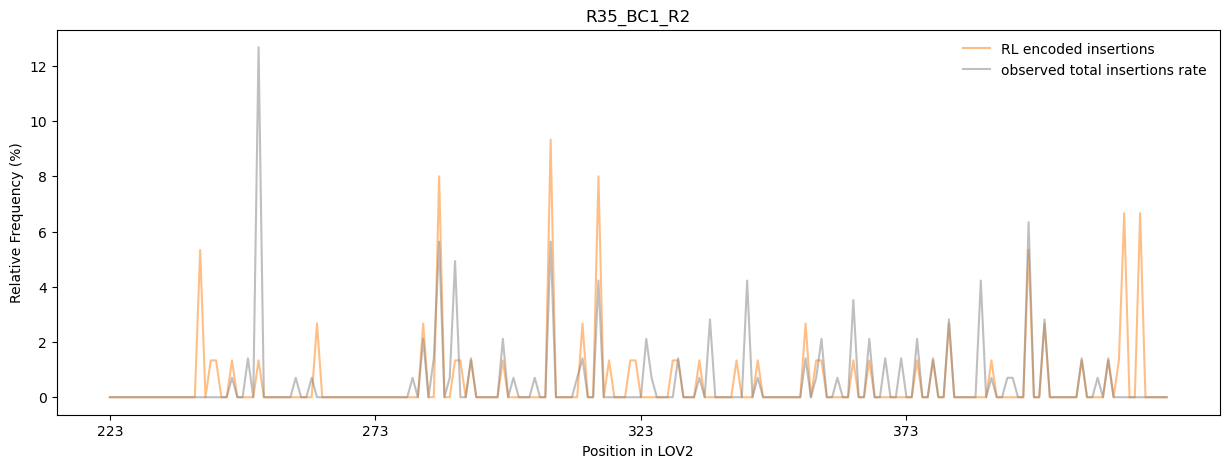

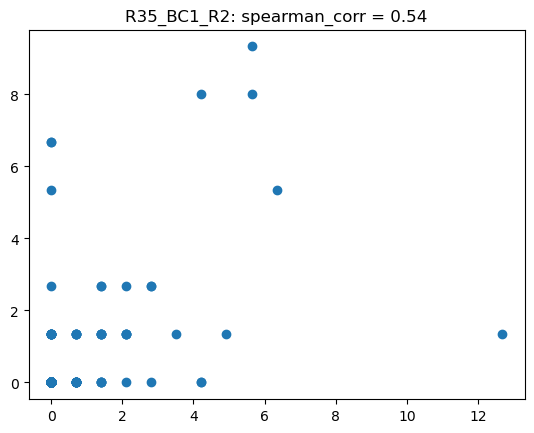

In [103]:
insertions_freq_prop = list(indels_freq.loc["insertion"]/np.sum(indels_freq.loc["insertion"])*100)
RL_insertion_roi = RL_encoded_insertions[LOV2_start_idx:LOV2_start_idx+len(insertions_freq_prop)] if read_dir=="R1" else RL_encoded_insertions[LOV2_end_idx- len(insertions_freq_prop) :LOV2_end_idx]
RL_insertion_roi = RL_insertion_roi/np.sum(RL_insertion_roi)*100

fig, ax = plt.subplots(figsize=(15, 5))
plt.xlabel("Position in LOV2")
plt.ylabel("Relative Frequency (%)")
plt.plot(RL_insertion_roi, label="RL encoded insertions", alpha=0.5, c = "tab:orange")
plt.plot(insertions_freq_prop, label = "observed total insertions rate", alpha = 0.5, c = "grey")
if read_dir == "R2":
    plt.xticks(np.arange(0, len(insertions_freq_prop), 50), np.arange(len(LOV2_gene)- len(insertions_freq_prop),len(LOV2_gene), 50))
else: 
    plt.xticks(np.arange(0, 250, 50), np.arange(0,250, 50))
plt.legend(frameon=False)
plt.title(f"{variant}_{Bc}_{read_dir}")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_insertions.pdf")
plt.show()
plt.clf()

plt.scatter(insertions_freq_prop, RL_insertion_roi)
plt.title(f"{variant}_{Bc}_{read_dir}: spearman_corr = {round(scipy.stats.spearmanr(insertions_freq_prop, RL_insertion_roi)[0],2)}")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_insertions_corr.pdf")
plt.show()

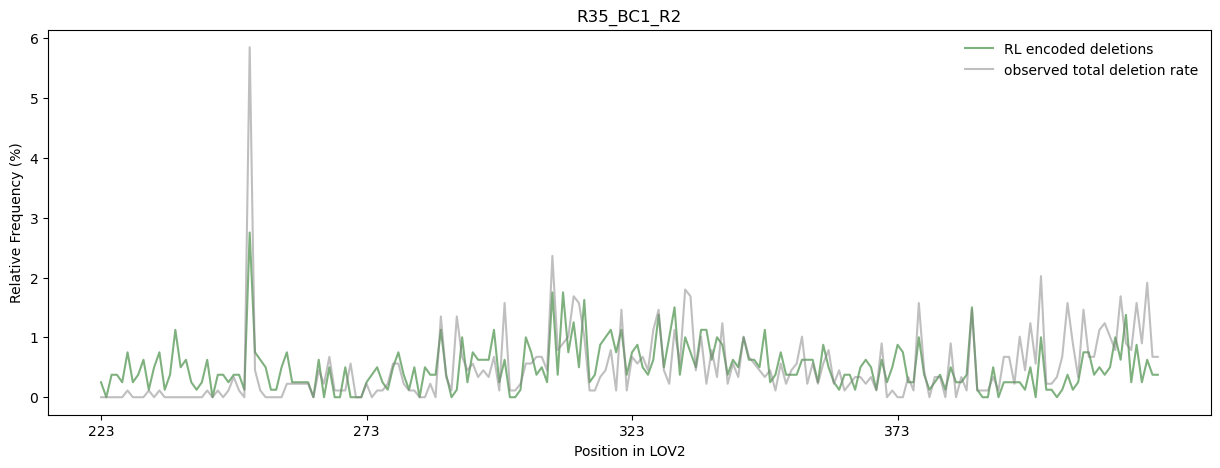

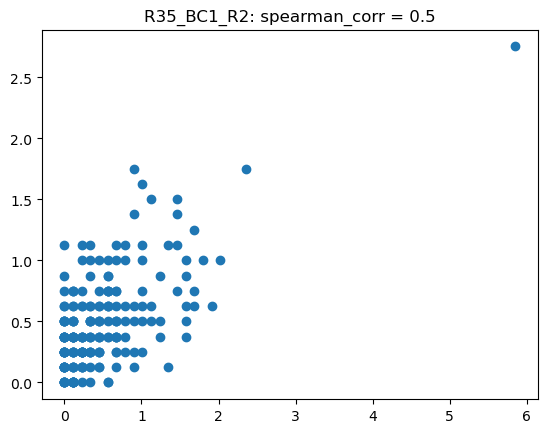

In [104]:
deletions_freq_prop = list(indels_freq.loc["deletion"]/np.sum(indels_freq.loc["deletion"])*100)
RL_del_roi = RL_encoded_deletions[LOV2_start_idx:LOV2_start_idx+len(deletions_freq_prop)] if read_dir=="R1" else RL_encoded_deletions[LOV2_end_idx- len(deletions_freq_prop) :LOV2_end_idx]
RL_del_roi = RL_del_roi/np.sum(RL_del_roi)*100

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(RL_del_roi, label="RL encoded deletions", alpha=0.5, c = "darkgreen")
plt.plot(deletions_freq_prop, label = "observed total deletion rate", alpha = 0.5, c = "grey")
plt.xlabel("Position in LOV2")
plt.ylabel("Relative Frequency (%)")
if read_dir == "R2":
    plt.xticks(np.arange(0, len(deletions_freq_prop), 50), np.arange(len(LOV2_gene)- len(deletions_freq_prop),len(LOV2_gene), 50))
else: 
    plt.xticks(np.arange(0, 250, 50), np.arange(0,250, 50))
plt.legend(frameon=False)
plt.title(f"{variant}_{Bc}_{read_dir}")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_deletions.pdf")
plt.show()
plt.clf()

plt.scatter(deletions_freq_prop, RL_del_roi)
plt.title(f"{variant}_{Bc}_{read_dir}: spearman_corr = {round(scipy.stats.spearmanr(deletions_freq_prop, RL_del_roi)[0],2)}")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_deletions_corr.pdf")
plt.show()

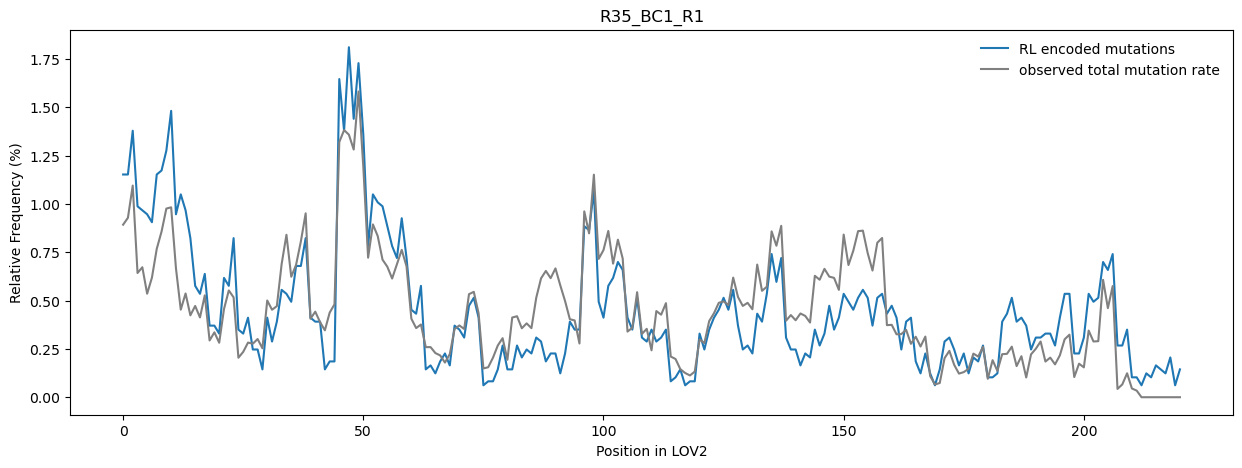

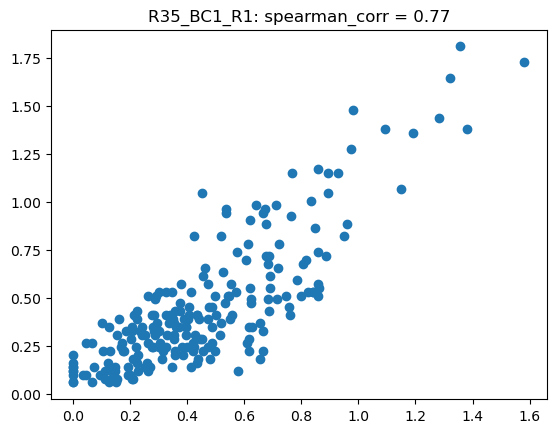

In [99]:
total_mut_rate = enrichment_relative.sum()
changes_roi = RL_encoded_mutations[LOV2_start_idx:LOV2_start_idx+len(total_mut_rate)] if read_dir=="R1" else RL_encoded_mutations[LOV2_end_idx- len(total_mut_rate) :LOV2_end_idx]
total_mut_rate_prop = [x/sum(total_mut_rate)*100 for x in total_mut_rate]
changes_roi_prop = [x/sum(changes_roi)*100 for x in changes_roi]

fig, ax = plt.subplots(figsize=(15, 5))
if read_dir == "R2":
    plt.xticks(np.arange(0, len(changes_roi_prop), 50), np.arange(len(LOV2_gene)- len(changes_roi_prop),len(LOV2_gene), 50))
else: 
    plt.xticks(np.arange(0, len(changes_roi_prop), 50), np.arange(0, len(changes_roi_prop), 50))
plt.xlabel("Position in LOV2")
plt.ylabel("Relative Frequency (%)")
plt.plot(changes_roi_prop, label="RL encoded mutations", c = "tab:blue")
plt.plot(total_mut_rate_prop, label = "observed total mutation rate", c = "grey")
plt.legend(frameon=False)
plt.title(f"{variant}_{Bc}_{read_dir}")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_mutations.pdf")
plt.show()
plt.clf()

plt.scatter(total_mut_rate_prop, changes_roi_prop)
plt.title(f"{variant}_{Bc}_{read_dir}: spearman_corr = {round(scipy.stats.spearmanr(total_mut_rate_prop, changes_roi_prop)[0],2)}")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_mutations_corr.pdf")
plt.show()
